<a href="https://colab.research.google.com/github/ShrutiAggarwal99/udacity-deep-learning-with-pytorch/blob/master/L6_CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np

In [2]:
# CIFAR 10 data

# transforms
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# train and test datasets
train_data = datasets.CIFAR10(root='data', train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10(root='data', train=False, transform=test_transform, download=True)

# choosing the indices for validation set
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
valid_idx, train_idx = indices[:split], indices[split:]

# samplers to load batches of validation and train data
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)

# prepare data loaders (combining data and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

# classes
output_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

170500096it [00:04, 41146565.06it/s]                               


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Visualizing a batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

torch.Size([20, 3, 32, 32])


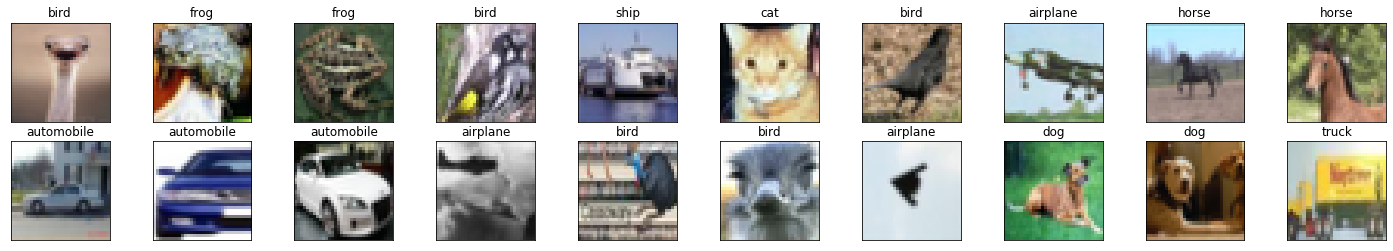

In [4]:
images, labels = next(iter(train_loader))

print(images.shape)

# convert images to numpy for display
images = images.numpy() # convert images to numpy for display


fig = plt.figure(figsize=(25,4))
for i in range(20):
  ax = fig.add_subplot(2,10,i+1, xticks=[], yticks=[])

  ax.imshow(np.transpose(images[i], (1,2,0)))   # set last dimension in image to be the number of color channels to display the image
  ax.set_title(output_classes[labels[i]])

## Looking at one image in detail

Looking at the 3 color channels of a single image separately - as grayscale intensity images

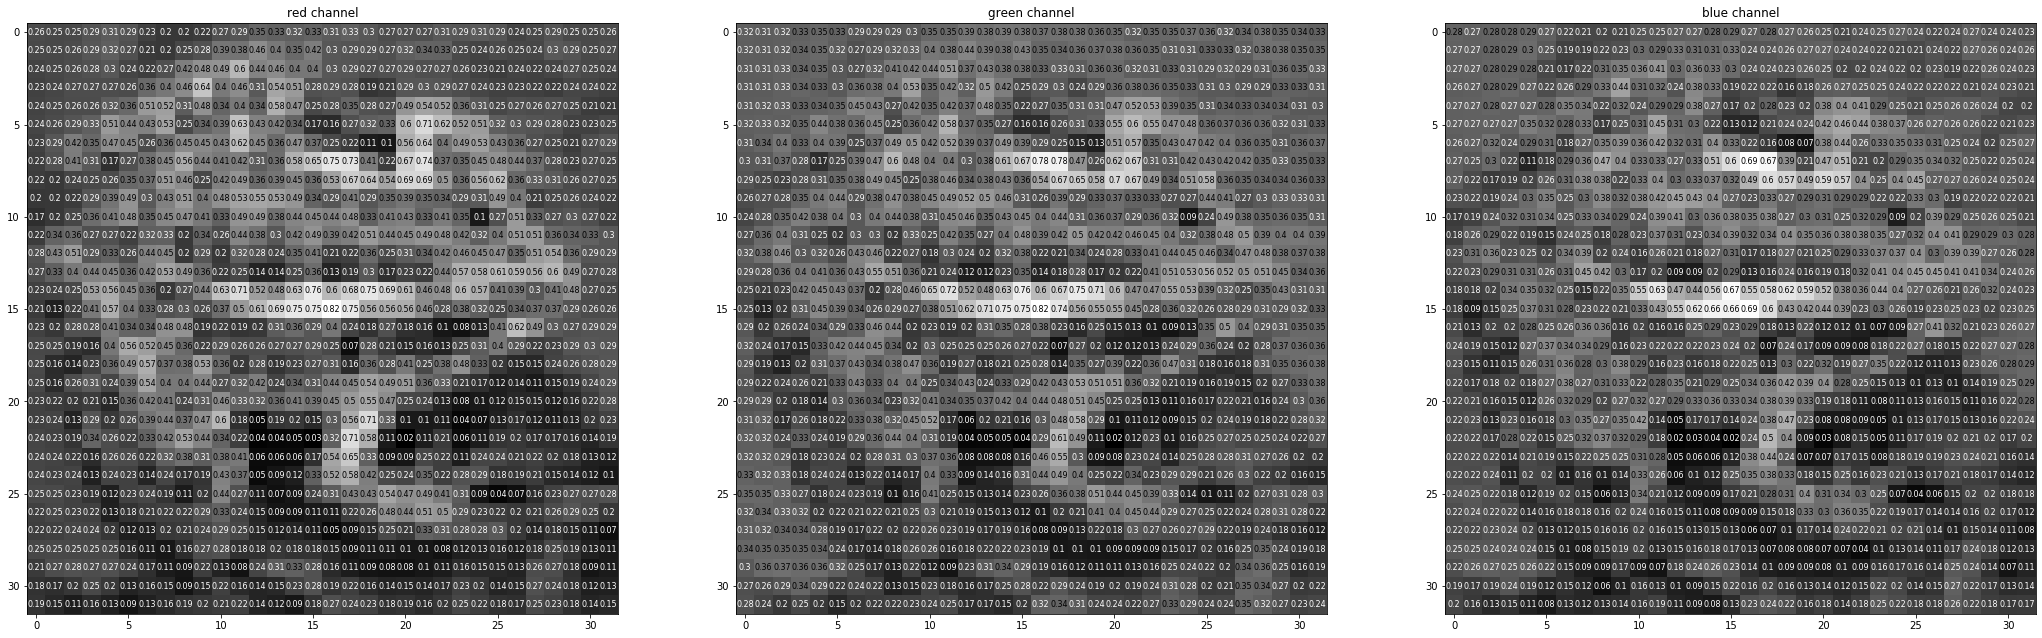

In [5]:
channels = ['red channel','green channel','blue channel']

img = np.squeeze(images[2])

fig = plt.figure(figsize=(36,36))

for idx in range(len(channels)):

  curr_channel = img[idx]
  ax = fig.add_subplot(1,3,idx+1)
  ax.imshow(curr_channel, cmap='gray')
  ax.set_title(channels[idx])

  width, height = curr_channel.shape
  thresh = curr_channel.max()/2.5

  # displaying the grayscale intensity as well, for every pixel in each color channel of the image
  for x in range(width):
      for y in range(height):
          val = round(curr_channel[x][y],2) if curr_channel[x][y] !=0 else 0
          ax.annotate(str(val), xy=(y,x),
                  horizontalalignment='center',
                  verticalalignment='center', size=8,
                  color='white' if curr_channel[x][y]<thresh else 'black')

# Defining the Network Architecture

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [35]:
# Defining the CNN architecture, that will learn from this CIFAR 10 dataset

class Network(nn.Module):

  def __init__(self):
    super().__init__()

    # Convolutional layers - applies a 2d convolution(kernel) over input volume
        # arguments : (no. of channels in input, no. of output channels, kernel size)

    # convolution layer (sees 3x32x32 image tensors)
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)    
    # conv layer (sees 16x16x16 image tensors)
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
    # conv layer (sees 32x8x8 image tensors)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)

    # max pooling layer
    self.pool = nn.MaxPool2d(2, stride=2)    # arguments : (kernel size for max pooling, stride)

    # FC(linear) layers
    self.fc1 = nn.Linear(4*4*64, 512)
    self.fc2 = nn.Linear(512,256)
    self.final = nn.Linear(256,10)

    # dropout layer
    self.dropout = nn.Dropout(p=0.25)

  def forward(self,x):
    x = self.dropout(self.pool(F.relu(self.conv1(x))))  # After : x is now (16x16x16) tensor
    x = self.dropout(self.pool(F.relu(self.conv2(x))))  # After : x is now (32x8x8) tensor
    x = self.dropout(self.pool(F.relu(self.conv3(x))))  # After : x is now (64x4x4) tensor

    x = x.view(-1,64*4*4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.final(x), dim=1)

    return x


model = Network()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(next(model.parameters()).is_cuda)

True


In [36]:
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (final): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

# Loss function and Optimizer

In [0]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training the Model (CNN)

In [38]:
epochs = 20

min_valid_loss = np.Inf

for e in range(epochs):
  train_loss = 0
  valid_loss = 0
  valid_accuracy = 0
  
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    batch_size = images.shape[0]
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*batch_size

  with torch.no_grad():
    model.eval()
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)
      batch_size = images.shape[0]
      log_ps = model(images)
      loss = criterion(log_ps,labels)
      valid_loss += loss.item()*batch_size
      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(k=1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      valid_accuracy += torch.mean(equals.type(torch.FloatTensor))*batch_size
  model.train()

  # Average losses and accuracy
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  valid_accuracy = valid_accuracy/len(valid_loader.sampler)

  print("Epoch: ", e+1,
        "   Training loss:", train_loss,
        "   Validation Loss:", valid_loss,
        "   Validation Accuracy:", valid_accuracy)
 
  if valid_loss < min_valid_loss:
    torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth')
    print("Validation loss decreased: ", min_valid_loss, "to ", valid_loss, "    Model saved..")
    min_valid_loss = valid_loss

Epoch:  1    Training loss: 1.6767174248993397    Validation Loss: 1.4388291773796082    Validation Accuracy: tensor(0.4672)
Validation loss decreased:  inf to  1.4388291773796082     Model saved..
Epoch:  2    Training loss: 1.3506480975747108    Validation Loss: 1.2240234160423278    Validation Accuracy: tensor(0.5687)
Validation loss decreased:  1.4388291773796082 to  1.2240234160423278     Model saved..
Epoch:  3    Training loss: 1.1936155571937561    Validation Loss: 1.0507807386517525    Validation Accuracy: tensor(0.6310)
Validation loss decreased:  1.2240234160423278 to  1.0507807386517525     Model saved..
Epoch:  4    Training loss: 1.090968894675374    Validation Loss: 0.9982100479602813    Validation Accuracy: tensor(0.6453)
Validation loss decreased:  1.0507807386517525 to  0.9982100479602813     Model saved..
Epoch:  5    Training loss: 1.0241100892573596    Validation Loss: 0.9647800272703171    Validation Accuracy: tensor(0.6617)
Validation loss decreased:  0.998210047

In [39]:
# Loading the best validated model saved..

checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Test the trained network 

In [40]:
test_loss = 0
test_accuracy = 0

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  batch_size = images.shape[0]
  log_ps = model(images)
  loss = criterion(log_ps,labels)
  test_loss += loss.item()*batch_size
  ps = torch.exp(log_ps)
  top_p, top_class = ps.topk(k=1, dim=1)
  equals = top_class == labels.view(*top_class.shape)
  test_accuracy += torch.mean(equals.type(torch.FloatTensor))*batch_size

# Average losses and accuracy
test_loss = test_loss/len(test_loader.dataset)
test_accuracy = test_accuracy/len(test_loader.dataset)

print("Test Loss:", test_loss,
      "   Test Accuracy:", test_accuracy*100)

Test Loss: 1.0259594881832599    Test Accuracy: tensor(65.9000)


# Visualizing the test results

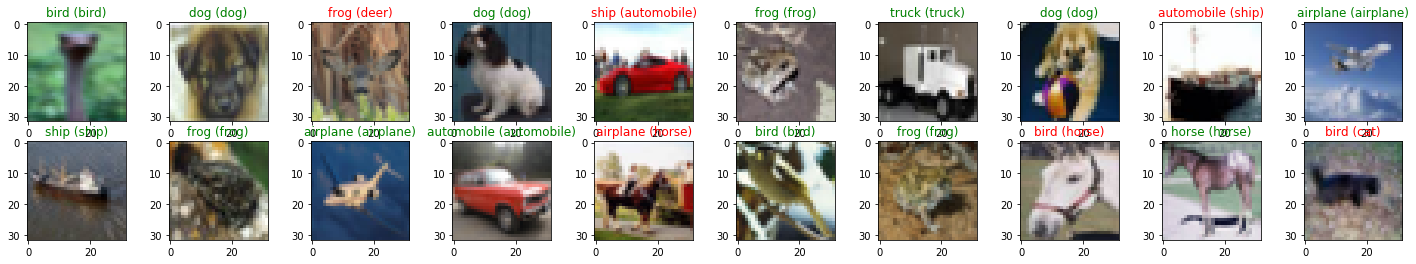

In [41]:
# Take one batch of test data

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

log_ps = model(images)
ps = torch.exp(log_ps)
top_p, top_class = ps.topk(k=1, dim=1)

fig = plt.figure(figsize=(25,4))
images = images.to('cpu')
for idx in range(20):
  ax = fig.add_subplot(2,10,idx+1)
  ax.imshow(np.transpose(images[idx],(1,2,0)))
  ax.set_title("{} ({})".format(output_classes[top_class[idx]], output_classes[labels[idx]]),
                 color=("green" if top_class[idx]==labels[idx].item() else "red"))